![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Introduction to Machine Learning </center>
## <center> Lecture 21 - Autoencoders</center>
### <center> Denoising Autoencoders</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/IntroductionToMachineLearning/21_Autoencoders/MainDenoisingAutoEncoder.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib
import torch

For Colab users:

In [3]:
!wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/IntroductionToMachineLearning/21_Autoencoders/AutoenDenoisingAutoencoderExampleAuxcoderExampleAux.py

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
#-- Record figures during training:
from DenoisingAutoencoderExampleAux import Plot, Recorder, TrainLoop, ValidationLoop, TrainModel, LearningRateSweep, OneCycleScheduler

### Load MNIST data:

In [5]:
import torchvision.transforms as transforms
import torchvision

dataPath  = '../../data/'
oTrainSet = torchvision.datasets.MNIST(root=dataPath, train=True,  transform=transforms.ToTensor(), download=True)
oTestSet  = torchvision.datasets.MNIST(root=dataPath, train=False, transform=transforms.ToTensor(), download=True)

### Encoder:

In [6]:
import torch.nn as nn
import torchsummary

def GetEncoder():
    oEncoder = nn.Sequential(
        nn.Sequential(),
        nn.Conv2d(1,  10, kernel_size=3, bias=False), nn.BatchNorm2d(10), nn.ReLU(), 
        nn.Conv2d(10, 20, kernel_size=3, bias=False), nn.BatchNorm2d(20), nn.ReLU(),
        nn.Conv2d(20, 40, kernel_size=3, bias=False), nn.BatchNorm2d(40), nn.ReLU(),
        nn.Conv2d(40, 60, kernel_size=3, bias=False), nn.BatchNorm2d(60), nn.ReLU(),
        nn.Conv2d(60, 60, kernel_size=3, bias=False), nn.BatchNorm2d(60), nn.ReLU(), nn.MaxPool2d(2),
        nn.Conv2d(60, 60, kernel_size=3, bias=False), nn.BatchNorm2d(60), nn.ReLU(),
        nn.Conv2d(60, 60, kernel_size=3, bias=False), nn.BatchNorm2d(60), nn.ReLU(),
        nn.Conv2d(60, 60, kernel_size=3, bias=False), nn.BatchNorm2d(60), nn.ReLU(),
        nn.Conv2d(60, 60, kernel_size=3, bias=False), nn.BatchNorm2d(60), nn.ReLU(),
        nn.Conv2d(60, 10, kernel_size=1), 
    )
    
    return oEncoder

torchsummary.summary(GetEncoder(), (1, 28, 28), device='cpu')
print('')

------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 28, 28]           --
├─Conv2d: 1-2                            [-1, 10, 26, 26]          90
├─BatchNorm2d: 1-3                       [-1, 10, 26, 26]          20
├─ReLU: 1-4                              [-1, 10, 26, 26]          --
├─Conv2d: 1-5                            [-1, 20, 24, 24]          1,800
├─BatchNorm2d: 1-6                       [-1, 20, 24, 24]          40
├─ReLU: 1-7                              [-1, 20, 24, 24]          --
├─Conv2d: 1-8                            [-1, 40, 22, 22]          7,200
├─BatchNorm2d: 1-9                       [-1, 40, 22, 22]          80
├─ReLU: 1-10                             [-1, 40, 22, 22]          --
├─Conv2d: 1-11                           [-1, 60, 20, 20]          21,600
├─BatchNorm2d: 1-12                      [-1, 60, 20, 

### Decoder:

In [7]:
def GetDecoder():
    oDecoder = nn.Sequential(
        nn.Sequential(),
        nn.Upsample(scale_factor=3), nn.Conv2d(10, 10, kernel_size=2, padding=1, bias=False), nn.BatchNorm2d(10), nn.ReLU(), 
        nn.Upsample(scale_factor=2), nn.Conv2d(10, 20, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(20), nn.ReLU(), 
                                     nn.Conv2d(20, 30, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(30), nn.ReLU(), 
        nn.Upsample(scale_factor=2), nn.Conv2d(30, 40, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(40), nn.ReLU(), 
        nn.Upsample(scale_factor=2), nn.Conv2d(40, 40, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(40), nn.ReLU(), 
                                     nn.Conv2d(40, 40, kernel_size=3,            bias=False), nn.BatchNorm2d(40), nn.ReLU(), 
                                     nn.Conv2d(40, 1,  kernel_size=3), nn.Sigmoid(), 
    )

    return oDecoder

torchsummary.summary(GetDecoder(), (10, 1, 1), device='cpu')
print('')

------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10, 1, 1]            --
├─Upsample: 1-2                          [-1, 10, 3, 3]            --
├─Conv2d: 1-3                            [-1, 10, 4, 4]            400
├─BatchNorm2d: 1-4                       [-1, 10, 4, 4]            20
├─ReLU: 1-5                              [-1, 10, 4, 4]            --
├─Upsample: 1-6                          [-1, 10, 8, 8]            --
├─Conv2d: 1-7                            [-1, 20, 8, 8]            1,800
├─BatchNorm2d: 1-8                       [-1, 20, 8, 8]            40
├─ReLU: 1-9                              [-1, 20, 8, 8]            --
├─Conv2d: 1-10                           [-1, 30, 8, 8]            5,400
├─BatchNorm2d: 1-11                      [-1, 30, 8, 8]            60
├─ReLU: 1-12                             [-1, 30, 8, 8]  

### Full model (autoencoder):

In [8]:
def GetModel():
    oModel = nn.Sequential(nn.Sequential(), GetEncoder(), GetDecoder())
    return oModel

torchsummary.summary(GetModel(), (1, 28, 28), device='cpu')
print('')

------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 28, 28]           --
├─Sequential: 1-2                        [-1, 10, 1, 1]            --
|    └─Sequential: 2-1                   [-1, 1, 28, 28]           --
|    └─Conv2d: 2-2                       [-1, 10, 26, 26]          90
|    └─BatchNorm2d: 2-3                  [-1, 10, 26, 26]          20
|    └─ReLU: 2-4                         [-1, 10, 26, 26]          --
|    └─Conv2d: 2-5                       [-1, 20, 24, 24]          1,800
|    └─BatchNorm2d: 2-6                  [-1, 20, 24, 24]          40
|    └─ReLU: 2-7                         [-1, 20, 24, 24]          --
|    └─Conv2d: 2-8                       [-1, 40, 22, 22]          7,200
|    └─BatchNorm2d: 2-9                  [-1, 40, 22, 22]          80
|    └─ReLU: 2-10                        [-1, 40, 22, 22] 

### Data loaders, device, and loss function:

In [9]:
batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   num_workers=1)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=1)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda', index=0)

In [11]:
import torch.optim as optim
LossFunc = nn.MSELoss()

### Search learning rates:

<IPython.core.display.Javascript object>


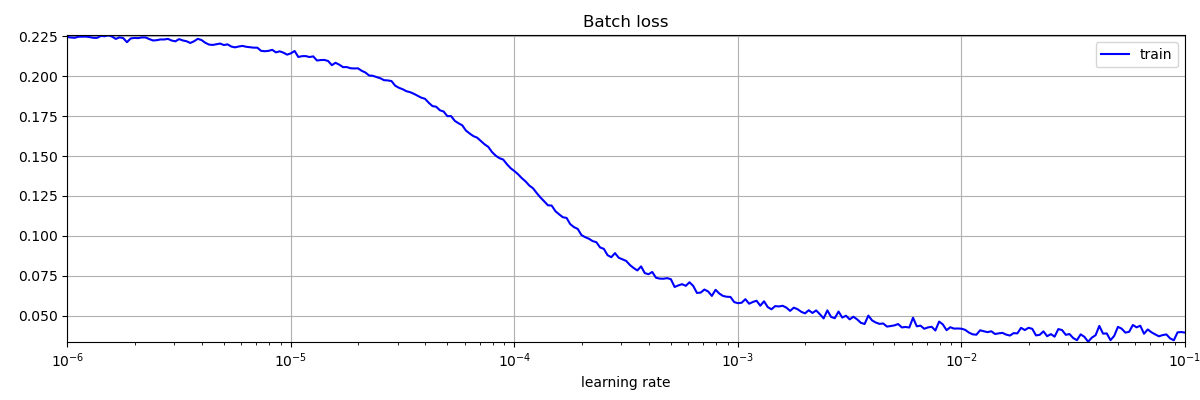

In [12]:
%matplotlib notebook
#-- Colab users should use `inline`
# %matplotlib inline

oModel        = GetModel().to(device)
oOptim        = optim.AdamW(oModel.parameters(), lr=0.1, betas=(0.9, 0.99), weight_decay=1e-4)
vLearningRate = np.logspace(-6, -1, 301)
oRecorder     = LearningRateSweep(oModel, oTrainDL, LossFunc, oOptim, vLearningRate)

In [13]:
#%matplotlib inline
oRecorder.fig

<IPython.core.display.Javascript object>

### Train the model:
We add noise to the training data inside the `TrainModel` function.

<IPython.core.display.Javascript object>


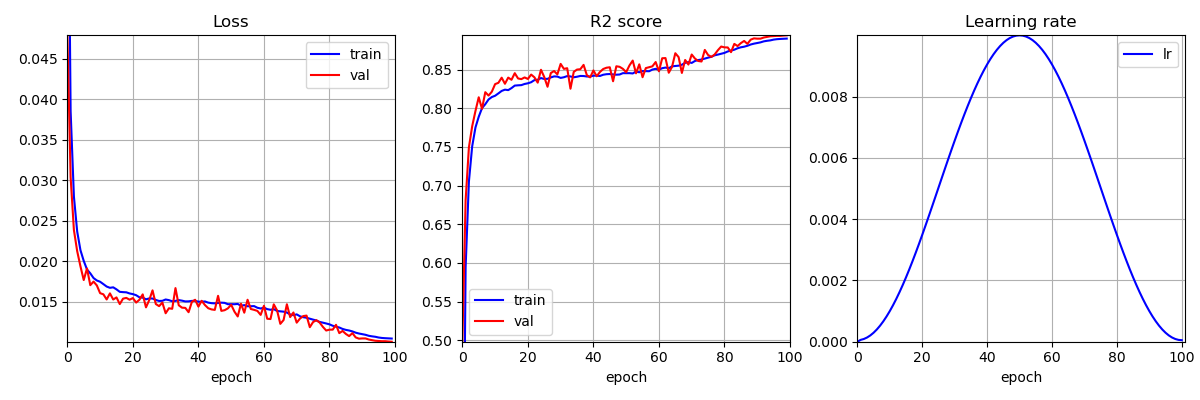

Epoch   0: | Train loss: 0.08171 | Val loss: 0.04786 | Train R2 score: 0.1391 | Val R2 score: 0.4982 | epoch time: 27.096 | <-- Checkpoint!
Epoch   1: | Train loss: 0.03849 | Val loss: 0.03034 | Train R2 score: 0.5944 | Val R2 score: 0.6811 | epoch time: 29.044 | <-- Checkpoint!
Epoch   2: | Train loss: 0.02798 | Val loss: 0.02384 | Train R2 score: 0.7052 | Val R2 score: 0.7494 | epoch time: 29.138 | <-- Checkpoint!
Epoch   3: | Train loss: 0.02365 | Val loss: 0.02123 | Train R2 score: 0.7507 | Val R2 score: 0.7767 | epoch time: 29.013 | <-- Checkpoint!
Epoch   4: | Train loss: 0.02134 | Val loss: 0.01935 | Train R2 score: 0.7751 | Val R2 score: 0.7964 | epoch time: 29.283 | <-- Checkpoint!
Epoch   5: | Train loss: 0.02002 | Val loss: 0.01766 | Train R2 score: 0.7890 | Val R2 score: 0.8142 | epoch time: 28.728 | <-- Checkpoint!
Epoch   6: | Train loss: 0.01896 | Val loss: 0.01908 | Train R2 score: 0.8002 | Val R2 score: 0.7993 | epoch time: 28.719 |
Epoch   7: | Train loss: 0.01849 | V

Epoch  64: | Train loss: 0.01384 | Val loss: 0.01392 | Train R2 score: 0.8541 | Val R2 score: 0.8535 | epoch time: 28.735 |
Epoch  65: | Train loss: 0.01379 | Val loss: 0.01225 | Train R2 score: 0.8546 | Val R2 score: 0.8711 | epoch time: 28.242 | <-- Checkpoint!
Epoch  66: | Train loss: 0.01376 | Val loss: 0.01273 | Train R2 score: 0.8550 | Val R2 score: 0.8661 | epoch time: 28.288 |
Epoch  67: | Train loss: 0.01364 | Val loss: 0.01467 | Train R2 score: 0.8562 | Val R2 score: 0.8456 | epoch time: 28.717 |
Epoch  68: | Train loss: 0.01341 | Val loss: 0.01309 | Train R2 score: 0.8587 | Val R2 score: 0.8624 | epoch time: 28.496 |
Epoch  69: | Train loss: 0.01331 | Val loss: 0.01365 | Train R2 score: 0.8597 | Val R2 score: 0.8565 | epoch time: 29.590 |
Epoch  70: | Train loss: 0.01342 | Val loss: 0.01240 | Train R2 score: 0.8586 | Val R2 score: 0.8694 | epoch time: 29.566 |
Epoch  71: | Train loss: 0.01318 | Val loss: 0.01290 | Train R2 score: 0.8611 | Val R2 score: 0.8642 | epoch time: 2

In [14]:
%matplotlib notebook

oModel = GetModel().to(device)
oOptim = optim.AdamW(oModel.parameters(), lr=0, betas=(0.9, 0.99), weight_decay=2e-2)

numEpochs     = 100
iterPerEpoch  = len(oTrainDL)
numIter       = numEpochs * iterPerEpoch
minLR         = 5e-5
maxLR         = 1e-2
vLearningRate = minLR + .5 * (maxLR - minLR) * (1 + np.cos(np.arange(numIter) / numIter * 2*np.pi + np.pi))

oScheduler = OneCycleScheduler(oOptim, vLearningRate)
TrainModel(oModel, oTrainDL, oTestDL, LossFunc, numEpochs, oOptim, oScheduler)

In [52]:
# torch.save(oModel.state_dict(), 'MainDenoisingAutoEncoder1.pt')

In [16]:
!wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/IntroductionToMachineLearning/21_Autoencoders/MainDenoisingAutoEncoder1.pt

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [17]:
#-- Run this to load a trained model:
# oModel = GetModel()
# oModel.load_state_dict(torch.load('MainDenoisingAutoEncoder1.pt'))
# oModel.to(device)
# oModel.train(False)
# print()

### Test the model:

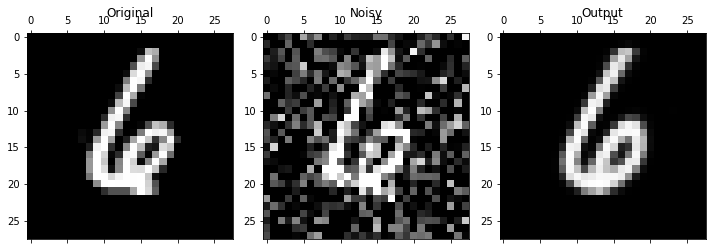

In [50]:
#%matplotlib inline

# mX, y = oTrainSet[np.random.randint(len(oTrainSet))]
mX, y = oTestSet[np.random.randint(len(oTestSet))]
mXN   = mX + torch.randn(mX.size()) / 3
mXN.clamp_(0, 1)
mHatX = oModel(mXN.unsqueeze(0).cuda()).squeeze(0)


_, axs = plt.subplots(1, 3, figsize=(10, 8))
axs[0].matshow(mX.squeeze(),                   cmap='gray'); axs[0].set_title('Original')
axs[1].matshow(mXN.squeeze(),                  cmap='gray'); axs[1].set_title('Noisy')
axs[2].matshow(mHatX.detach().cpu().squeeze(), cmap='gray'); axs[2].set_title('Output')
plt.tight_layout()
plt.show()

### Generate data:

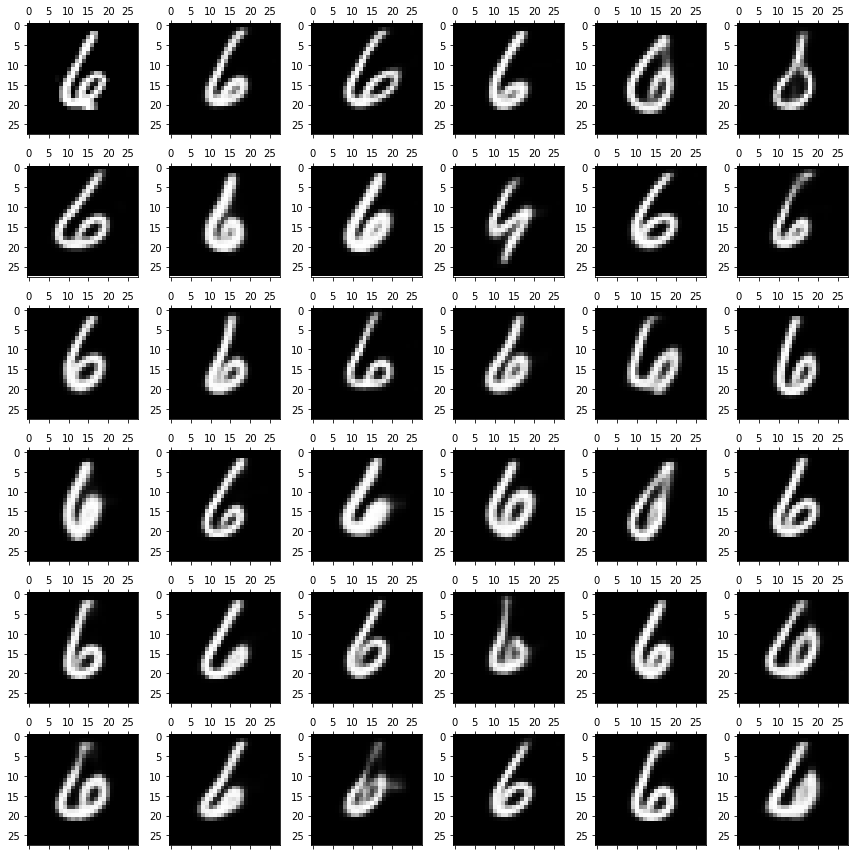

In [51]:
#-- Get encoder:
oEncoder = oModel[1]
#-- Encode a single example:
vZ       = oEncoder(mX.unsqueeze(0).to(device)).squeeze()
#-- Add some (small) noise:
mZ       = vZ[None,:] + .8 * (torch.rand(35, 10, device=device) - 1/2)

#-- Get decoder:
oDecoder = oModel[2]
oDecoder.to(device)
#-- Decode the pertubed data:
mHatX    = oDecoder(mZ[:,:,None,None])

#-- Plot:
fig, _   = plt.subplots(6, 6, figsize=(12, 12))
for ii, ax in enumerate(fig.axes):
    if ii == 0:
        ax.matshow(mX.detach().cpu().squeeze(), cmap='gray')
    else:
        ax.matshow(mHatX[ii-1].detach().cpu().squeeze(), cmap='gray')

plt.tight_layout()
plt.show()